In [1]:
from pathlib import Path
from datetime import datetime
import fiona
import numpy as np
from distributed import Client, performance_report
from dask_jobqueue import SLURMCluster

cwd = Path.cwd()
out_dir = cwd.joinpath('results', 's1_ratio_db_median')
vec = cwd.joinpath('vec', 'malalane.geojson')
now = datetime.now().strftime('%Y%m%dT%H%M')

n_workers = 1
threads_per_worker = 20
mem_limit = "50GB"

cluster = SLURMCluster(cores=threads_per_worker, processes=n_workers, memory=mem_limit, walltime="01:00:00")
dask_client = Client(cluster)
cluster.scale(jobs=1)
cluster

In [2]:
product = 's1_rtc'
measurements = ('vh', 'vv')

time_range = ('2019-01-01', '2020-12-31')
bbox = fiona.open(vec, 'r').bounds
x = (bbox[0], bbox[2])
y = (bbox[1], bbox[3])
output_crs = 'EPSG:4326'
resolution = (-0.0002, 0.0002)
resampling = 'bilinear'

dask_chunks = {'time': 1, 'latitude': 256, 'longitude': 256}
dask_rechunk = {'time': -1}

# 1. EO3 metadata - local - datacube-core

Not applicable on this system.

# 2. STAC metadata - local

In [ ]:
from pystac import Catalog
from utils import filter_stac_catalog

catalog = Catalog.from_file("/geonfs/04_vol1/Saldi/original_data/Sentinel1/s1_rtc/catalog.json")
collections, items = filter_stac_catalog(catalog=catalog, bbox=bbox, time_range=time_range)
len(items)

## 2.1. odc-stac 

In [ ]:
%%time
from odc.stac import load as stac_load

data_odcstac_local = stac_load(items, bands=measurements, bbox=bbox, crs=output_crs, resolution=resolution[1],
                               resampling=resampling, chunks=dask_chunks)
data_odcstac_local['ratio_db'] = 10 * np.log10(data_odcstac_local.vh / data_odcstac_local.vv)
data_odcstac_local = data_odcstac_local.chunk(chunks=dask_rechunk)

with performance_report(filename=out_dir.joinpath(f"{now}_{vec.stem}_stac-local-odcstac_{n_workers}-{threads_per_worker}-{mem_limit}.html")):
    result_odcstac_local = data_odcstac_local.ratio_db.median(dim='time', skipna=True).compute()

In [ ]:
data_odcstac_local.ratio_db

In [ ]:
result_odcstac_local.plot(robust=True, cmap='gray')

## 2.2. stackstac

In [ ]:
%%time
import stackstac
from rasterio.enums import Resampling

chunksize = (1,) + tuple(dask_chunks.values())
data_stackstac_local = stackstac.stack(items=items, assets=list(measurements), bounds=bbox, epsg=int(output_crs.removeprefix("EPSG:")), 
                                       resolution=resolution[1], resampling=Resampling[resampling], chunksize=chunksize, dtype=np.float32)
vh = data_stackstac_local.sel(band='vh')
vv = data_stackstac_local.sel(band='vv')
data_stackstac_local['ratio_db'] = 10 * np.log10(vh / vv)
data_stackstac_local = data_stackstac_local.chunk(chunks=dask_rechunk)

with performance_report(filename=out_dir.joinpath(f"{now}_{vec.stem}_stac-local-stackstac_{n_workers}-{threads_per_worker}-{mem_limit}.html")):
    result_stackstac_local = data_stackstac_local.ratio_db.median(dim='time', skipna=True).compute()

In [ ]:
data_stackstac_local.ratio_db

In [ ]:
result_stackstac_local.plot(robust=True, cmap='gray')

# 3. STAC metadata - remote - odc-stac

[3] https://odc-stac.readthedocs.io/en/latest/notebooks/stac-load-S2-deafrica.html

In [4]:
from odc.stac import configure_rio
import pystac_client

configure_rio(cloud_defaults=True, aws={"aws_unsigned": True}, AWS_S3_ENDPOINT="s3.af-south-1.amazonaws.com", client=dask_client)
remote_catalog = pystac_client.Client.open("https://explorer.digitalearth.africa/stac")
items = remote_catalog.search(bbox=bbox, collections=[product], datetime=f"{time_range[0]}/{time_range[1]}", max_items=None).get_all_items()

In [5]:
%%time
from odc.stac import load as stac_load

data_odcstac_remote = stac_load(items, bands=measurements, bbox=bbox, crs=output_crs, resolution=resolution[1],
                                resampling=resampling, chunks=dask_chunks)
data_odcstac_remote['ratio_db'] = 10 * np.log10(data_odcstac_remote.vh / data_odcstac_remote.vv)
data_odcstac_remote = data_odcstac_remote.chunk(chunks=dask_rechunk)

with performance_report(filename=out_dir.joinpath(f"{now}_{vec.stem}_stac-remote-odcstac_{n_workers}-{threads_per_worker}-{mem_limit}.html")):
    result_odcstac_remote = data_odcstac_remote.ratio_db.median(dim='time', skipna=True).compute()

CPU times: user 58.2 s, sys: 3.37 s, total: 1min 1s
Wall time: 7min 1s


In [6]:
data_odcstac_remote.ratio_db

<xarray.DataArray 'ratio_db' (time: 169, latitude: 777, longitude: 1188)>
dask.array<rechunk-merge, shape=(169, 777, 1188), dtype=float32, chunksize=(169, 256, 256), chunktype=numpy.ndarray>
Coordinates:
  * latitude     (latitude) float64 -25.38 -25.38 -25.38 ... -25.54 -25.54
  * longitude    (longitude) float64 31.4 31.4 31.4 31.4 ... 31.63 31.63 31.63
    spatial_ref  int32 4326
  * time         (time) datetime64[ns] 2019-01-06T03:18:46.924630 ... 2020-12...

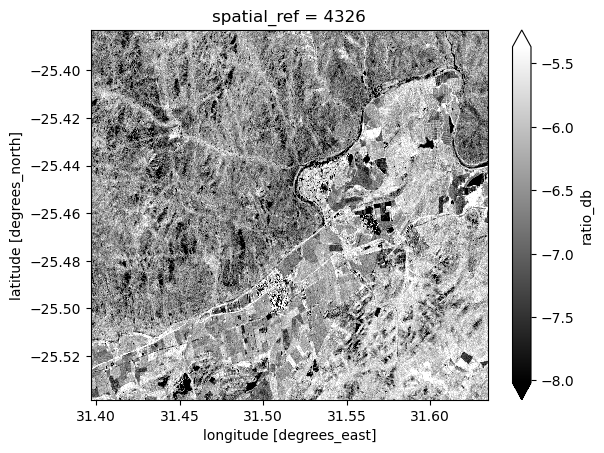

In [7]:
result_odcstac_remote.plot(robust=True, cmap='gray')

-----

## Additional information

In [10]:
import datacube
import odc.stac
import odc.geo
import stackstac
import rasterio
import pystac
import pystac_client
print(f"datacube=={datacube.__version__}")
print(f"odc.stac=={odc.stac.__version__}")
print(f"odc.geo=={odc.geo.__version__}")
print(f"stackstac=={stackstac.__version__}")
print(f"rasterio=={rasterio.__version__}")
print(f"pystac=={pystac.__version__}")
print(f"pystac_client=={pystac_client.__version__}")

datacube==1.8.12
odc.stac==0.3.5
odc.geo==0.3.3
stackstac==0.4.3
rasterio==1.3.6
pystac==1.7.3
pystac_client==0.6.1


In [9]:
!lscpu | grep -v "Vulnerability" | grep -v "Flags" 

Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              144
On-line CPU(s) list: 0-143
Thread(s) per core:  2
Core(s) per socket:  36
Socket(s):           2
NUMA node(s):        2
Vendor ID:           GenuineIntel
CPU family:          6
Model:               106
Model name:          Intel(R) Xeon(R) Platinum 8360Y CPU @ 2.40GHz
Stepping:            6
CPU MHz:             2400.000
CPU max MHz:         3500.0000
CPU min MHz:         800.0000
BogoMIPS:            4800.00
L1d cache:           48K
L1i cache:           32K
L2 cache:            1280K
L3 cache:            55296K
NUMA node0 CPU(s):   0-35,72-107
NUMA node1 CPU(s):   36-71,108-143
